In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#!pip install fancyimpute==0.7.0 imblearn==0.0 joblib==1.3.1 matplotlib==3.7.2 numpy==1.24.4 pandas==1.3.5 scikit-learn==1.3.0 scipy==1.10.1 seaborn==0.12.2 six==1.16.0 xgboost==1.7.6
#chardet

In [5]:
#pip install ipywidgets --upgrade


In [51]:
import os
import math
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import shap
import yfinance as yf
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import boxcox, shapiro, skew, anderson
from statsmodels.graphics.gofplots import qqplot
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.metrics import (
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    log_loss,
    cohen_kappa_score,
    average_precision_score,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (
    train_test_split as tts,
    GridSearchCV,
    cross_val_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    MaxAbsScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    OneHotEncoder,
    LabelBinarizer,
    OrdinalEncoder,
    minmax_scale
)
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import plot_importance, XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from typing import Dict, List
from warnings import filterwarnings
from matplotlib import pyplot
from plotly.offline import init_notebook_mode
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from IPython.display import display

# Suppress warnings
filterwarnings('ignore')

# Data Visualization
%matplotlib inline
init_notebook_mode(connected=True)


In [2]:
import operator

In [3]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [4]:
import pandas as pd
file_path = 'loan_approval_dataset_updated.csv'

In [5]:
import chardet

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read(10000))
    
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [7]:
def fill_missing_values(df):
    for column in df.columns:
        if df[column].dtype == 'object':  
            mode_value = df[column].mode()[0]
            df[column].fillna(mode_value, inplace=True)
        else:  
            median_value = df[column].median()
            df[column].fillna(median_value, inplace=True)
    return df

In [8]:
def detect_outliers_iqr(df):
    outlier_columns = []
    
    
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

       
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

       
        if not outliers.empty:
            outlier_columns.append(col)
    
    return outlier_columns




In [9]:
def cap_outliers(series):
    lower_bound = series.quantile(0.01)
    upper_bound = series.quantile(0.99)
    return series.clip(lower_bound, upper_bound)

In [10]:

df = pd.read_csv(file_path, encoding='ISO-8859-1', sep=';')

In [11]:
df.columns = df.columns.str.strip()

In [12]:
df.head()

,loan_id,no_of_dependents,City,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Ankara,Graduate,No,9600000,29900000,12,778.0,2400000.0,17600000,22700000,8000000,Approved
1,2,0,Ankara,Not Graduate,Yes,4100000,12200000,8,417.0,2700000.0,2200000,8800000,3300000,Rejected
2,3,3,Ankara,Graduate,No,9100000,29700000,20,NaN,7100000.0,4500000,33300000,12800000,Rejected
3,4,3,Ankara,Graduate,No,8200000,30700000,8,NaN,18200000.0,3300000,23300000,7900000,Rejected
4,5,5,Ankara,Not Graduate,Yes,9800000,24200000,20,NaN,12400000.0,8200000,29400000,5000000,Rejected


In [13]:
check_df(df)

##################### Shape #####################
(4269, 14)
##################### Types #####################
loan_id                       int64
no_of_dependents              int64
City                         object
education                    object
self_employed                object
income_annum                  int64
loan_amount                   int64
loan_term                     int64
cibil_score                 float64
residential_assets_value    float64
commercial_assets_value       int64
luxury_assets_value           int64
bank_asset_value              int64
loan_status                  object
dtype: object
##################### Head #####################
   loan_id  no_of_dependents    City      education self_employed  \
0        1                 2  Ankara       Graduate            No   
1        2                 0  Ankara   Not Graduate           Yes   
2        3                 3  Ankara       Graduate            No   
3        4                 3  Ankara       Gra

In [14]:
duplicate_loan_ids = df[df.duplicated(subset=['loan_id'])]
print(f"Number of duplicate loan_id rows: {duplicate_loan_ids.shape[0]}")

Number of duplicate loan_id rows: 0


In [15]:
df.drop('loan_id', axis=1, inplace=True)

In [16]:
df['City'] = df['City'].str.replace('Ý', 'I')

### NA Values

In [17]:
missing_percentage = df.isnull().sum() / len(df) * 100
missing_percentage

no_of_dependents            0.000000
City                        3.654252
education                   1.991099
self_employed               0.000000
income_annum                0.000000
loan_amount                 0.000000
loan_term                   0.000000
cibil_score                 8.995081
residential_assets_value    2.881237
commercial_assets_value     0.000000
luxury_assets_value         0.000000
bank_asset_value            0.000000
loan_status                 0.000000
dtype: float64

In [18]:
df= fill_missing_values(df)

### Negative Value

In [19]:
numeric_columns = df.select_dtypes(include=['number']).columns
anomalies_df = {col: df[df[col] < 0][col].count() for col in numeric_columns}
anomalies_df

{'no_of_dependents': 0,
 'income_annum': 0,
 'loan_amount': 0,
 'loan_term': 0,
 'cibil_score': 0,
 'residential_assets_value': 28,
 'commercial_assets_value': 0,
 'luxury_assets_value': 0,
 'bank_asset_value': 0}

In [20]:
df['residential_assets_value'] = df['residential_assets_value'].apply(lambda x: np.nan if x < 0 else x)
df['residential_assets_value'].fillna(df['residential_assets_value'].median(), inplace=True)


### Outlier Handling

In [21]:
outlier_cols = detect_outliers_iqr(df)

print("Outlier tespit edilen kolonlar:")
print(outlier_cols)

Outlier tespit edilen kolonlar:
['residential_assets_value', 'commercial_assets_value', 'bank_asset_value']


In [22]:
df['residential_assets_value'] = cap_outliers(df['residential_assets_value'])
df['commercial_assets_value'] = cap_outliers(df['commercial_assets_value'])
df['bank_asset_value'] = cap_outliers(df['bank_asset_value'])


### EDA

In [23]:
df['loan_status'].value_counts() 

 Approved    2656
 Rejected    1613
Name: loan_status, dtype: int64

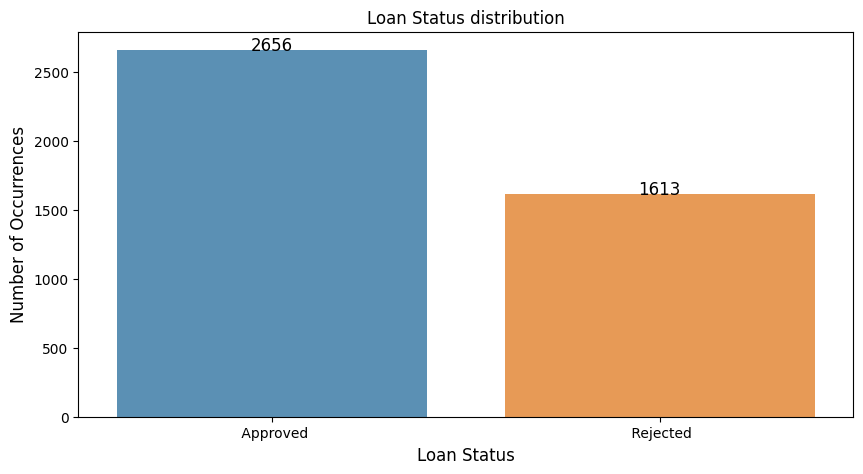

In [24]:
##########PLotting the loan status 
status=df['loan_status'].value_counts() 
plt.figure(figsize=(10,5))
ax = sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
for i, value in enumerate(status.values):
    ax.text(i, value + 0.5, str(value), ha='center', fontsize=12)
plt.show()

In [25]:
data = df.copy()

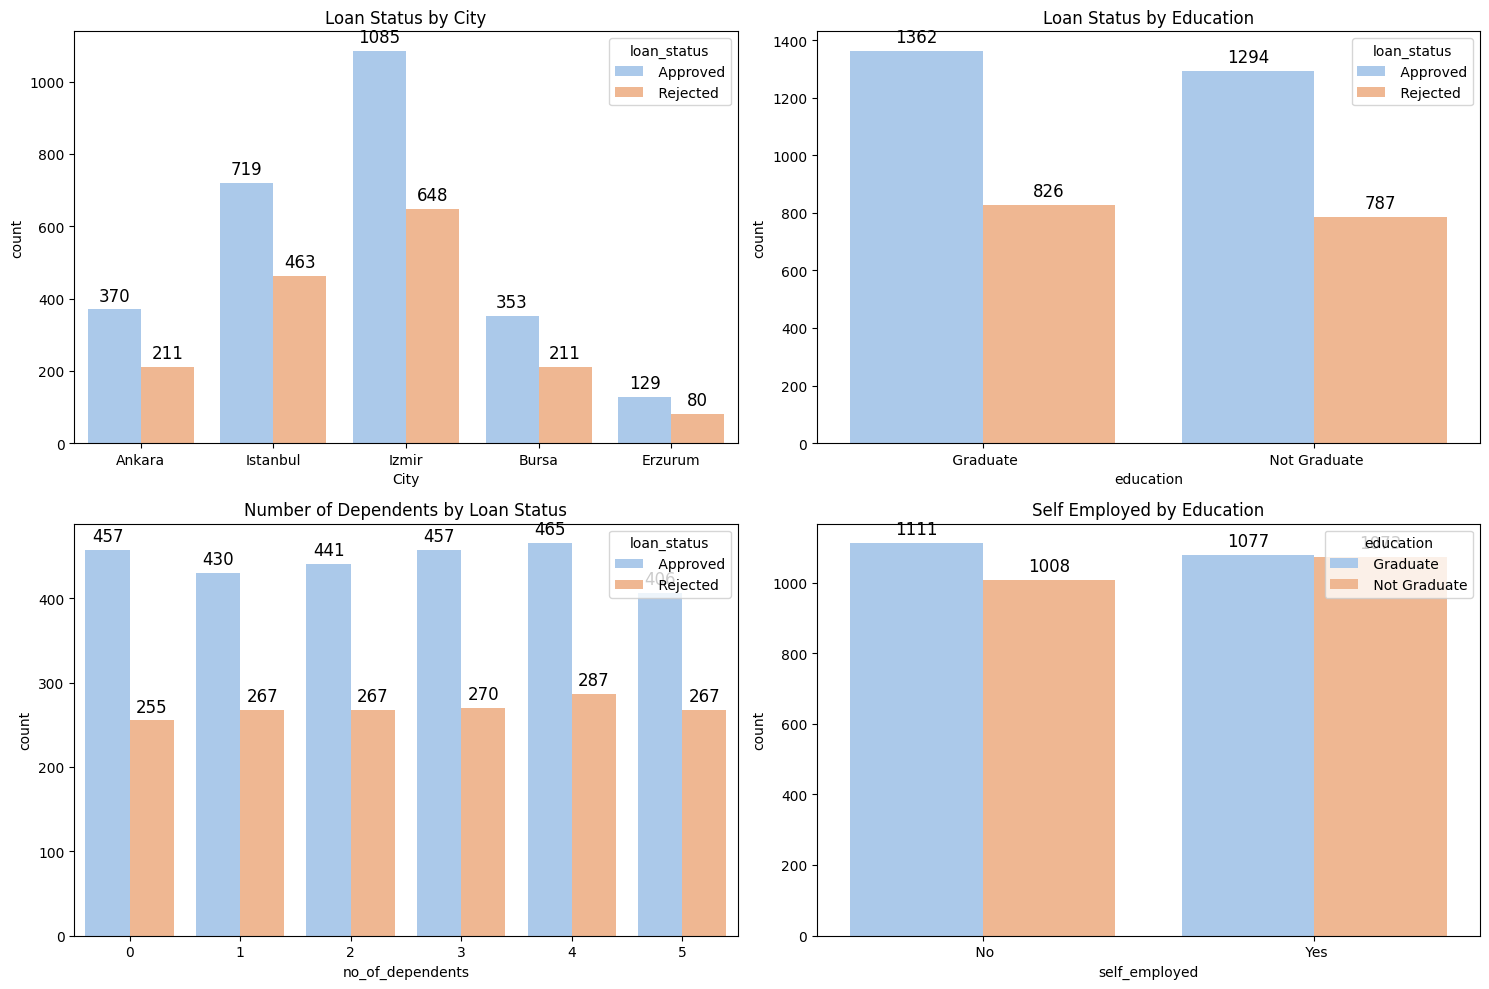

In [26]:
soft_colors = sns.color_palette("pastel")

fig, axs = plt.subplots(2, 2, figsize=(15, 10))


ax = sns.countplot(x='City', data=data, hue='loan_status', palette=soft_colors, ax=axs[0,0])
ax.set_title('Loan Status by City')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                textcoords='offset points')


ax = sns.countplot(x='education', data=data, hue='loan_status', palette=soft_colors, ax=axs[0,1])
ax.set_title('Loan Status by Education')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                textcoords='offset points')


ax = sns.countplot(x='no_of_dependents', data=data, hue='loan_status', palette=soft_colors, ax=axs[1,0])
ax.set_title('Number of Dependents by Loan Status')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                textcoords='offset points')
    

ax = sns.countplot(x='self_employed', data=data, hue='education', palette=soft_colors,ax=axs[1,1])
ax.set_title('Self Employed by Education')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

**Loan Status by City (Top Left Plot):**
Izmir has the highest number of approved loans (1085), followed by Istanbul (719). Ankara and Bursa show similar numbers, while Erzurum has the lowest number of approved loans.
In terms of rejected loans, Izmir leads, while Erzurum has the fewest rejections.

**Loan Status by Education (Top Right Plot):**
Among graduates, the number of approved loans (1362) is slightly higher compared to non-graduates (1294). Similarly, rejected loans are slightly higher for non-graduates (787) compared to graduates (826)


**Number of Dependents by Loan Status (Bottom Left Plot):**
There isn’t a significant difference in the number of approved loans based on the number of dependents. However, those with 0 and 4 dependents have slightly higher loan approval rates.
Rejected loans are more evenly distributed across different numbers of dependents.


**Self Employed by Education (Bottom Right Plot):**
Among self-employed individuals, non-graduates have slightly fewer approved loans. However, both self-employed graduates and non-graduates show similar numbers for loan approvals.

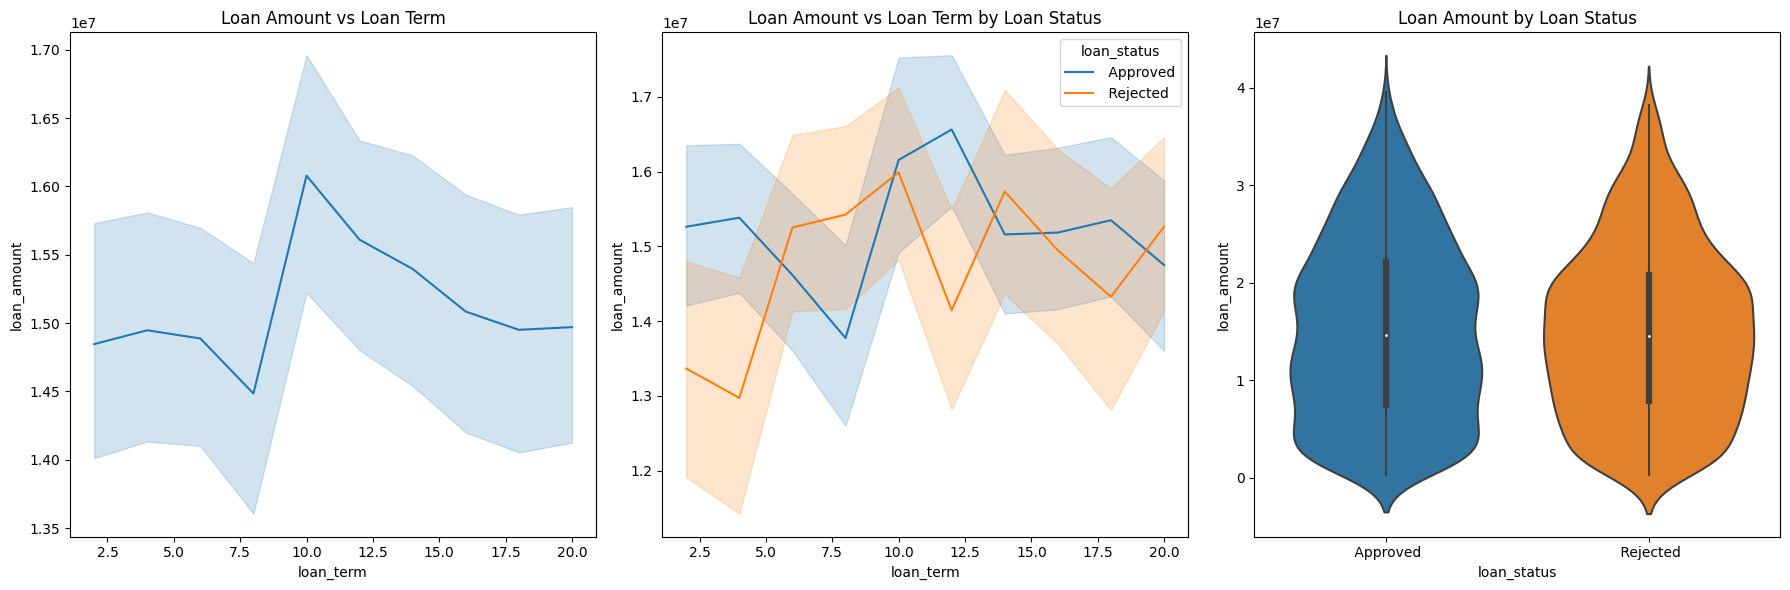

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax = sns.lineplot(x='loan_term', y='loan_amount', data=data, ax=axs[0])
ax.set_title('Loan Amount vs Loan Term')


ax = sns.lineplot(x='loan_term', y='loan_amount', data=data, hue='loan_status', ax=axs[1])
ax.set_title('Loan Amount vs Loan Term by Loan Status')


ax = sns.violinplot(x='loan_status', y='loan_amount', data=data, ax=axs[2])
ax.set_title('Loan Amount by Loan Status')


plt.tight_layout()
plt.show()

**Loan Amount vs Loan Term (Left Plot):**
This line plot shows the relationship between loan amount and loan term.
Overall, as the loan term increases, there is a downward trend in the loan amount. However, there is a noticeable increase in the loan amount between 7.5 and 10 years.
The shaded blue area represents the uncertainty or variability in the loan amount.

**Loan Amount vs Loan Term by Loan Status (Middle Plot):**
This plot compares the loan amount and loan term for approved and rejected loans.
For approved loans (blue line), there are some fluctuations in the loan amount over the term, but the general trend is associated with higher loan amounts.
Rejected loans (orange line) tend to have lower loan amounts overall and exhibit variability over the loan term.
The shaded areas represent the uncertainty in the loan amounts for each loan status category.


**Loan Amount by Loan Status (Right Plot):**
This violin plot shows the distribution of loan amounts for both approved and rejected loans.
Approved loans generally have higher loan amounts, as indicated by the higher median.
Rejected loans tend to have lower loan amounts, though there are some outliers as well.

<Axes: xlabel='Immovable_assets', ylabel='Count'>

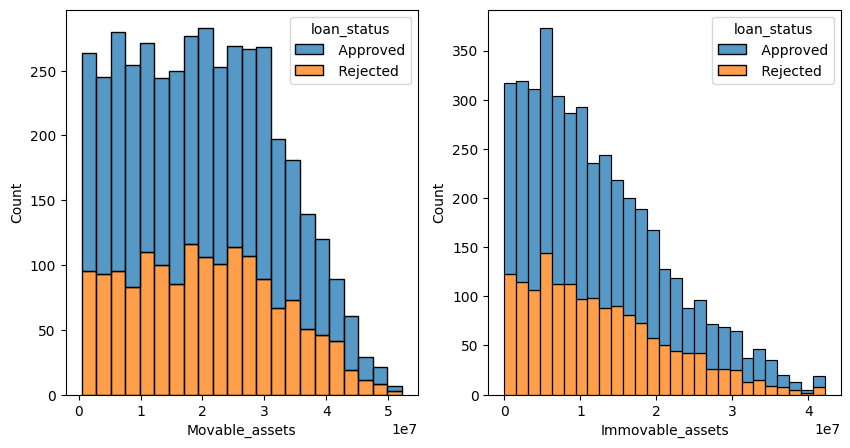

In [28]:
data['Movable_assets'] = data['bank_asset_value'] + data['luxury_assets_value']
data['Immovable_assets'] = data['residential_assets_value'] + data['commercial_assets_value']
fig, ax = plt.subplots(1,2,figsize=(10,5))
sns.histplot(x  = 'Movable_assets', data = data, ax=ax[0], hue = 'loan_status', multiple='stack')
sns.histplot(x =  'Immovable_assets', data = data, ax=ax[1], hue  = 'loan_status', multiple='stack')

 Applicants with higher assets—whether movable (e.g., luxury goods, bank balances) or immovable (e.g., real estate)—are more likely to have their loans approved. The key takeaway is that wealthier individuals, especially those with significant asset holdings, are seen as lower risk by lenders, which makes them more likely to be approved for loans.

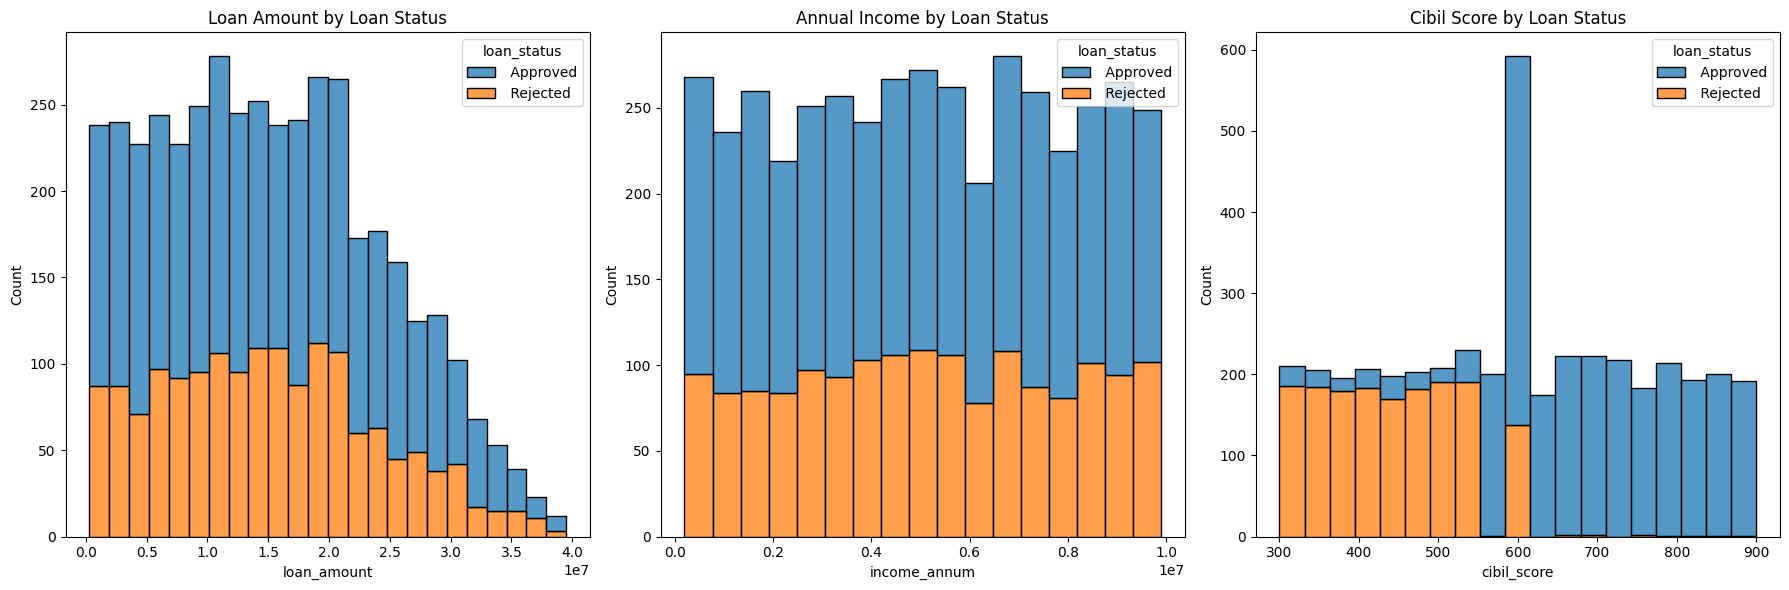

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Histogram 1: Loan Amount by Loan Status
sns.histplot(x='loan_amount', hue='loan_status', data=data, ax=axs[0], multiple='stack')
axs[0].set_title('Loan Amount by Loan Status')

# Histogram 2: Annual Income by Loan Status
sns.histplot(x='income_annum', hue='loan_status', data=data, ax=axs[1], multiple='stack')
axs[1].set_title('Annual Income by Loan Status')

# Histogram 3: Credit Score by Loan Status
sns.histplot(x='cibil_score', hue='loan_status', data=data, ax=axs[2], multiple='stack')
axs[2].set_title('Cibil Score by Loan Status')

plt.tight_layout()
plt.show()

- **Loan Amount by Loan Status**
Approved loans are mostly concentrated between 0.5 million and 2 million.
Rejected loans are more frequent for lower loan amounts. As the loan amount increases, the rejection rate decreases, but approved loans above 3.5 million are rare.

- **Annual Income by Loan Status**
Approved loans are spread across all income levels with a fairly even distribution.
Rejected loans also show a similar pattern across all income brackets. There is no significant increase in loan approvals as income levels rise.

- **CIBIL Score by Loan Status**
 Individuals with a CIBIL score of 600 have a much higher likelihood of approval, as seen by the large number of approved loans in this range.
Lower CIBIL scores, especially between 300 and 600, are associated with a higher rate of rejected loans.

In [30]:
# Calculate counts for each combination of loan_term and loan_status
count_term_status = data.groupby(['loan_term', 'loan_status']).size().reset_index(name='count')

# Calculate total counts for each loan_term
total_counts = count_term_status.groupby('loan_term')['count'].sum().reset_index(name='total_count')

# Merge total counts with the count_term_status to calculate percentages
count_term_status = count_term_status.merge(total_counts, on='loan_term')
count_term_status['percentage'] = (count_term_status['count'] / count_term_status['total_count'] * 100).round(0).astype(int)

#create a string of value of percentage
count_term_status['count_percentage'] = count_term_status['count'].astype(str).str.cat(count_term_status['percentage'].astype(str), sep='<br>(') + '%)'

fig = px.bar(count_term_status, x='loan_term', y='count', color='loan_status', text='count_percentage', width=700, height=500)

# Update x labels
fig.update_xaxes(tickangle=0, tickmode='array', tickvals=count_term_status['loan_term'], ticktext=count_term_status['loan_term'])

# Update layout for better visual appearance
fig.update_layout(xaxis_title = 'Loan Term in Year', 
                  yaxis_title = 'Count', 
                  title = {"text":"Loan Term Count by Status", 
                           "font":{'size': 18, 'color': 'black', 'weight':'bold'}, 
                           "x":0.5, 
                           "xanchor": "center"})

# Update traces to show text labels inside the bars with bold font
fig.update_traces(texttemplate='%{text}', 
                  textposition='inside', 
                  textfont=dict(size=9, color="white", weight="normal"))

# Add total count labels as an additional trace
for _, row in total_counts.iterrows():
    fig.add_annotation(
        x=row['loan_term'],
        y=row['total_count'],
        text=f"{row['total_count']}",
        showarrow=False,
        yshift=10,
        font=dict(size=10, color="black", weight="bold"),
        align="center")

# Show the figure
fig.show()


### Data correlation and matrix heatmap

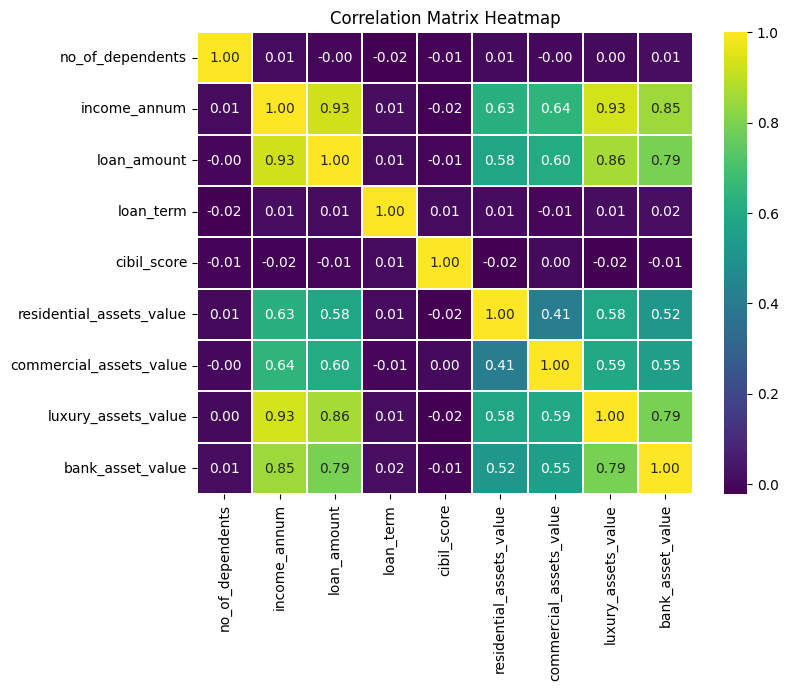

In [31]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = df_numeric.corr()
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.01)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [32]:
numeric_df = df.select_dtypes(include=[np.number])

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
print(vif_data)


                    feature        VIF
0          no_of_dependents   2.857072
1              income_annum  74.413843
2               loan_amount  27.247989
3                 loan_term   3.949443
4               cibil_score   6.109694
5  residential_assets_value   3.915477
6   commercial_assets_value   3.907737
7       luxury_assets_value  27.539455
8          bank_asset_value  12.322286


### Feature engineering and Selection

In [34]:
def feature_engineering(df):
    df['income_to_loan_ratio'] = df['income_annum'] / df['loan_amount']
    df['loan_term_to_income_ratio'] = df['loan_term'] / df['income_annum']
    df['loan_term'] = df['loan_term'] * 36
    df.drop(columns=[ 'income_annum'], inplace=True)
    return df

In [35]:
feature_engineering(df)


,no_of_dependents,City,education,self_employed,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,income_to_loan_ratio,loan_term_to_income_ratio
0,2,Ankara,Graduate,No,29900000,432,778.0,2400000.0,16732000.0,22700000,8000000.0,Approved,0.321070,1.250000e-06
1,0,Ankara,Not Graduate,Yes,12200000,288,417.0,2700000.0,2200000.0,8800000,3300000.0,Rejected,0.336066,1.951220e-06
2,3,Ankara,Graduate,No,29700000,720,597.0,7100000.0,4500000.0,33300000,12800000.0,Rejected,0.306397,2.197802e-06
3,3,Ankara,Graduate,No,30700000,288,597.0,18200000.0,3300000.0,23300000,7900000.0,Rejected,0.267101,9.756098e-07
4,5,Ankara,Not Graduate,Yes,24200000,720,597.0,12400000.0,8200000.0,29400000,5000000.0,Rejected,0.404959,2.040816e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,5,Izmir,Graduate,Yes,2300000,432,317.0,2800000.0,500000.0,3300000,800000.0,Rejected,0.434783,1.200000e-05
4265,0,Izmir,Not Graduate,Yes,11300000,720,559.0,4200000.0,2900000.0,11000000,1900000.0,Approved,0.292035,6.060606e-06
4266,2,Izmir,Not Graduate,No,23900000,648,457.0,1200000.0,12400000.0,18100000,7300000.0,Rejected,0.271967,2.769231e-06
4267,1,Izmir,Not Graduate,No,12800000,288,780.0,8200000.0,700000.0,14100000,5800000.0,Approved,0.320312,1.951220e-06


In [41]:
categorical_features = ['education', 'City', 'self_employed', 'loan_status']
rename_columns = {
    'education_ Graduate': 'education',
    'self_employed_ Yes': 'self_employed',
    'loan_status_ Approved': 'loan_status'
}
selected_columns = [
    'education_ Graduate', 'City_Ankara', 'City_Bursa', 'City_Erzurum',
    'City_Istanbul', 'City_Izmir', 'self_employed_ Yes', 'loan_status_ Approved'
]



In [42]:
def encode_categorical_features(dataframe: pd.DataFrame, features: list, rename_columns: dict, selected_columns: list = None) -> pd.DataFrame:
    categorical_df = dataframe[features]
    
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(categorical_df)
    
    encoded_dataframe = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(features))
    
    
    if selected_columns:
        encoded_dataframe = encoded_dataframe[selected_columns]
    
    
    dataframe_encoded = dataframe.drop(features, axis=1)
    dataframe_encoded = pd.concat([dataframe_encoded, encoded_dataframe], axis=1)
    
    dataframe_encoded.rename(columns=rename_columns, inplace=True)
    
    return dataframe_encoded

In [44]:

df_w_encode = encode_categorical_features(df, categorical_features, rename_columns, selected_columns)
df_w_encode.head()

,no_of_dependents,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,income_to_loan_ratio,loan_term_to_income_ratio,education,City_Ankara,City_Bursa,City_Erzurum,City_Istanbul,City_Izmir,self_employed,loan_status
0,2,29900000,432,778.0,2400000.0,16732000.0,22700000,8000000.0,0.321070,1.250000e-06,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,12200000,288,417.0,2700000.0,2200000.0,8800000,3300000.0,0.336066,1.951220e-06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,29700000,720,597.0,7100000.0,4500000.0,33300000,12800000.0,0.306397,2.197802e-06,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,30700000,288,597.0,18200000.0,3300000.0,23300000,7900000.0,0.267101,9.756098e-07,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,24200000,720,597.0,12400000.0,8200000.0,29400000,5000000.0,0.404959,2.040816e-06,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
numerical_features = [ 'loan_amount', 'loan_term', 'cibil_score', 
                      'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
df_w_numerical = df_w_encode[numerical_features]

In [47]:
rb_scaler = RobustScaler(quantile_range=(20,80))  # default quantile_range=(25,75)
rb_scaler.fit(df_w_numerical)

RobustScaler(quantile_range=(20, 80))

In [48]:
df_w_numerical_scaled = pd.DataFrame(rb_scaler.transform(df_w_numerical), columns=df_w_numerical.columns)
# Make a copy
df_w_encode_numerical_scaled = df_w_encode.copy()
# Assign the scaled features back to the dataframe with encode
df_w_encode_numerical_scaled[numerical_features] = df_w_numerical_scaled[numerical_features]

In [49]:

df_w_encode_numerical_scaled.head(2)

,no_of_dependents,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,income_to_loan_ratio,loan_term_to_income_ratio,education,City_Ankara,City_Bursa,City_Erzurum,City_Istanbul,City_Izmir,self_employed,loan_status
0,2,0.895349,0.2,0.543544,-0.288288,1.670769,0.468208,0.576271,0.321070,0.000001,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.133721,-0.2,-0.540541,-0.261261,-0.192308,-0.335260,-0.220339,0.336066,0.000002,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [52]:
x = df_w_encode_numerical_scaled.drop('loan_status', axis=1)
y = df_w_encode_numerical_scaled['loan_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28, stratify=y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3415, 17) (854, 17) (3415,) (854,)


In [53]:
def train_and_evaluate_models(x_train, x_test, y_train, y_test):
    ml_models = [("eXtremGradientBoosting", XGBClassifier()),  
                 ("GradientBoosting", GradientBoostingClassifier()), 
                 ("RandomForest", RandomForestClassifier()), 
                 ("DecisionTree", DecisionTreeClassifier())]
    
    for model in ml_models:
        print(f"Training {model[0]}...")
        model[1].fit(x_train, y_train)
        y_pred = model[1].predict(x_test)
        
        print(f"Model: {model[0]}")
        print(f"\troc_auc_score: {roc_auc_score(y_test, y_pred):.3f}")
        print(f"\tf1_score: {f1_score(y_test, y_pred):.3f}")
        print(f"\tMCC: {matthews_corrcoef(y_test, y_pred):.3f}")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {model[0]}')
        plt.show()


Training eXtremGradientBoosting...
Model: eXtremGradientBoosting
	roc_auc_score: 0.955
	f1_score: 0.969
	MCC: 0.918
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       323
         1.0       0.96      0.98      0.97       531

    accuracy                           0.96       854
   macro avg       0.96      0.95      0.96       854
weighted avg       0.96      0.96      0.96       854



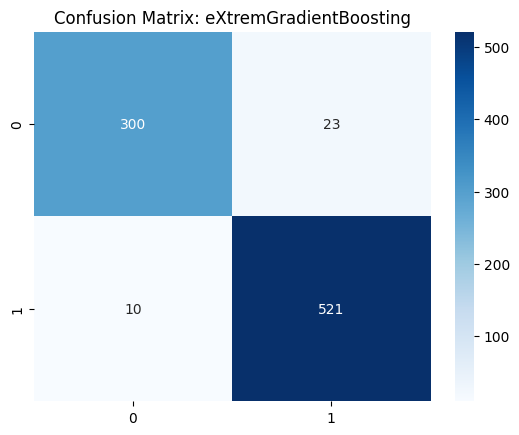

Training GradientBoosting...
Model: GradientBoosting
	roc_auc_score: 0.950
	f1_score: 0.969
	MCC: 0.916
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95       323
         1.0       0.95      0.99      0.97       531

    accuracy                           0.96       854
   macro avg       0.97      0.95      0.96       854
weighted avg       0.96      0.96      0.96       854



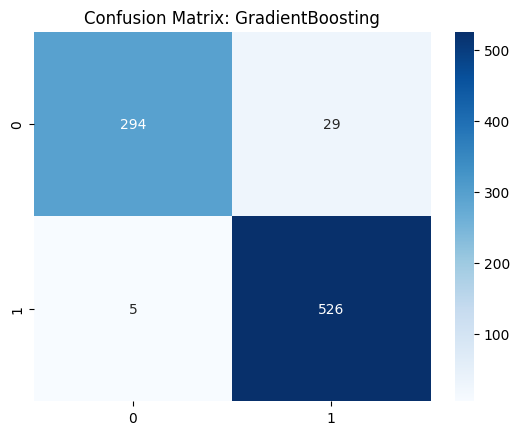

Training RandomForest...
Model: RandomForest
	roc_auc_score: 0.951
	f1_score: 0.971
	MCC: 0.922
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95       323
         1.0       0.94      1.00      0.97       531

    accuracy                           0.96       854
   macro avg       0.97      0.95      0.96       854
weighted avg       0.96      0.96      0.96       854



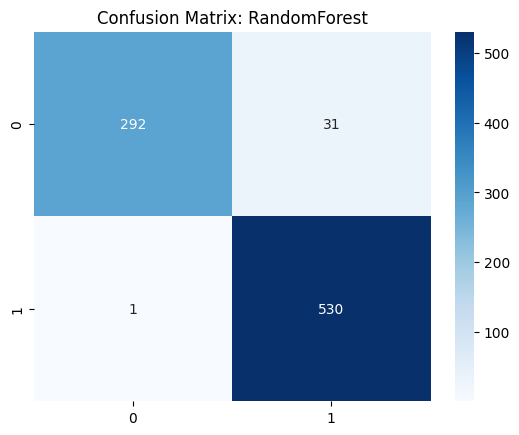

Training DecisionTree...
Model: DecisionTree
	roc_auc_score: 0.949
	f1_score: 0.961
	MCC: 0.898
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       323
         1.0       0.96      0.96      0.96       531

    accuracy                           0.95       854
   macro avg       0.95      0.95      0.95       854
weighted avg       0.95      0.95      0.95       854



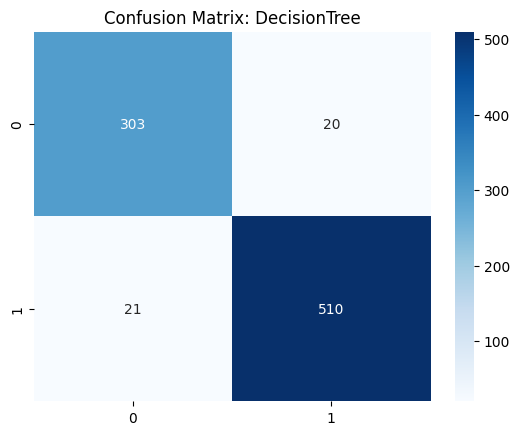

In [54]:
train_and_evaluate_models(x_train, x_test, y_train, y_test)

Performing GridSearchCV for eXtremGradientBoosting...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best params for eXtremGradientBoosting: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'subsample': 1.0}
eXtremGradientBoosting: 
	roc_auc_score:  0.956
	f1_score:  0.973
	MCC (Matthews Correlation Coefficient):  0.929

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       323
         1.0       0.95      1.00      0.97       531

    accuracy                           0.97       854
   macro avg       0.97      0.96      0.96       854
weighted avg       0.97      0.97      0.97       854

------------------------------------------------------------



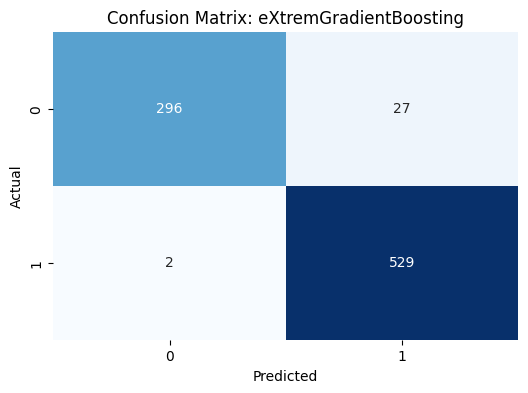

Performing GridSearchCV for GradientBoosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
GradientBoosting: 
	roc_auc_score:  0.95
	f1_score:  0.969
	MCC (Matthews Correlation Coefficient):  0.916

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95       323
         1.0       0.95      0.99      0.97       531

    accuracy                           0.96       854
   macro avg       0.97      0.95      0.96       854
weighted avg       0.96      0.96      0.96       854

------------------------------------------------------------



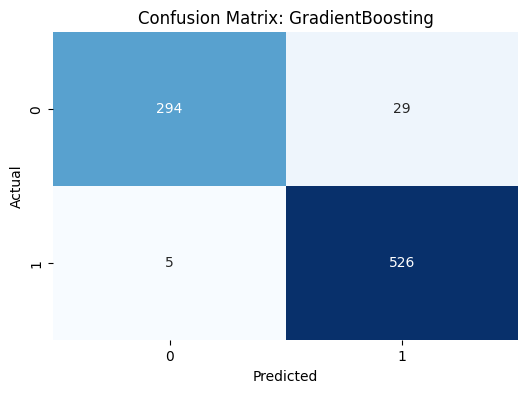

Performing GridSearchCV for RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for RandomForest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RandomForest: 
	roc_auc_score:  0.951
	f1_score:  0.971
	MCC (Matthews Correlation Coefficient):  0.922

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95       323
         1.0       0.94      1.00      0.97       531

    accuracy                           0.96       854
   macro avg       0.97      0.95      0.96       854
weighted avg       0.96      0.96      0.96       854

------------------------------------------------------------



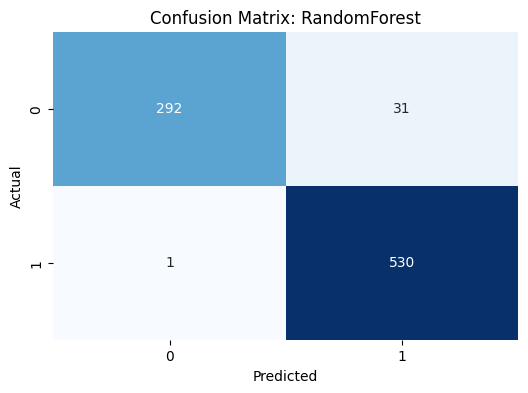

Performing GridSearchCV for DecisionTree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for DecisionTree: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
DecisionTree: 
	roc_auc_score:  0.948
	f1_score:  0.968
	MCC (Matthews Correlation Coefficient):  0.914

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       323
         1.0       0.94      0.99      0.97       531

    accuracy                           0.96       854
   macro avg       0.97      0.95      0.96       854
weighted avg       0.96      0.96      0.96       854

------------------------------------------------------------



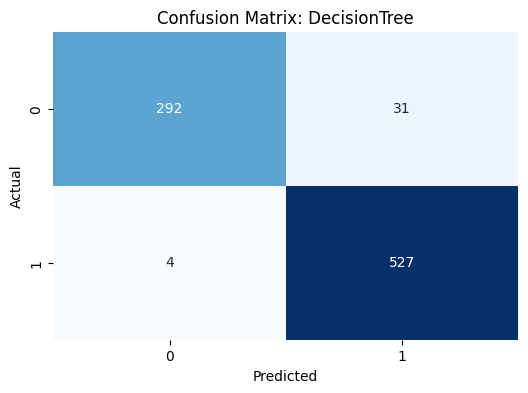

The best model is: eXtremGradientBoosting


In [63]:
param_grids = {
    "eXtremGradientBoosting": {
        'n_estimators': [10, 25, 50],
        'learning_rate': [0.1, 0.01, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3],
        'gamma': [0.1, 0.2], 
        'subsample': [0.8, 1.0], 
        'colsample_bytree': [0.8, 1.0]
    },
    "GradientBoosting": {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 5, 7]
    },
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "DecisionTree": {
        'max_depth': [5, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

ml_models = [("eXtremGradientBoosting", XGBClassifier()),  
             ("GradientBoosting", GradientBoostingClassifier()), 
             ("RandomForest", RandomForestClassifier()), 
             ("DecisionTree", DecisionTreeClassifier())]

best_models = {}

for model_name, model in ml_models:
    print(f"Performing GridSearchCV for {model_name}...")
    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grids[model_name], 
                               scoring='roc_auc', 
                               cv=5, 
                               verbose=1, 
                               n_jobs=-1)
    
    grid_search.fit(x_train, y_train)
    
    # Best model and params
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    print(f"Best params for {model_name}: {grid_search.best_params_}")
    
    # Evaluate the best model
    y_pred = best_model.predict(x_test)
    print(model_name + ": ")
    
    
    print('\troc_auc_score: ', round(roc_auc_score(y_test, y_pred), 3))
    print('\tf1_score: ', round(f1_score(y_test, y_pred), 3))
    print('\tMCC (Matthews Correlation Coefficient): ', round(matthews_corrcoef(y_test, y_pred), 3))
    
    
    print("\n" + classification_report(y_test, y_pred))
    print("-" * 60 + "\n")
    
   
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()


best_model_name = max(best_models, key=lambda name: best_models[name].score(x_test, y_test))
print(f"The best model is: {best_model_name}")


                      Feature  Importance
3                 cibil_score    0.590025
2                   loan_term    0.134495
8        income_to_loan_ratio    0.123491
9   loan_term_to_income_ratio    0.018368
5     commercial_assets_value    0.018230
7            bank_asset_value    0.016945
11                City_Ankara    0.016323
1                 loan_amount    0.015163
15                 City_Izmir    0.015064
4    residential_assets_value    0.014256
6         luxury_assets_value    0.012425
16              self_employed    0.010944
0            no_of_dependents    0.010325
10                  education    0.003948
12                 City_Bursa    0.000000
13               City_Erzurum    0.000000
14              City_Istanbul    0.000000


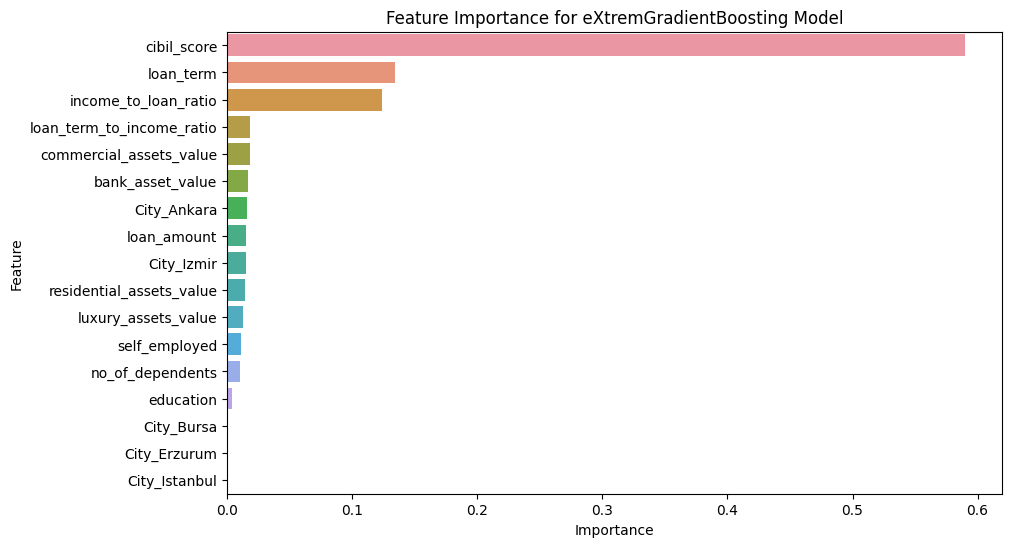

In [64]:
best_model = best_models["eXtremGradientBoosting"]
feature_importances = best_model.feature_importances_


features_df = pd.DataFrame({
    'Feature': x_train.columns, 
    'Importance': feature_importances
})


features_df = features_df.sort_values(by='Importance', ascending=False)


print(features_df)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importance for eXtremGradientBoosting Model')
plt.show()

In [65]:
!pip install streamlit -q

In [66]:
import streamlit as st
import joblib

In [67]:
joblib.dump(best_model, 'loan_approval_model.pkl')

['loan_approval_model.pkl']

In [68]:
joblib.dump(rb_scaler, 'rb_scaler.pkl')

['rb_scaler.pkl']

In [10]:
import joblib
import pandas as pd


model = joblib.load('loan_approval_model.pkl')

columns = [
    'no_of_dependents', 'loan_amount', 'loan_term', 'cibil_score', 
    'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 
    'bank_asset_value', 'income_to_loan_ratio', 'loan_term_to_income_ratio', 
    'education', 'City_Ankara', 'City_Bursa', 'City_Erzurum', 'City_Istanbul', 
    'City_Izmir', 'self_employed'
]


test_data = pd.DataFrame([[
    1, 300000, 10, 750, 100000, 50000, 30000, 40000, 0.6, 0.02, 
    1, 0, 0, 0, 1, 0, 0
]], columns=columns)


prediction = model.predict(test_data)


print(f"Tahmin sonucu: {prediction}")


Tahmin sonucu: [1]
